In [1]:
!pip install matplotlib networkx

In [2]:
# from time import sleep

In [3]:
from typing import Sequence, Tuple

import matplotlib.cm
import networkx as nx

NodeType = str
ColorType = int
EdgeType = Tuple[NodeType, NodeType]
FanType = Sequence[NodeType]

In [193]:
def edge_is_colored(g: nx.Graph, u: NodeType, v: NodeType) -> bool:
    return 'color' in g[u][v].keys()
def get_edge_color(g: nx.Graph, u: NodeType, v: NodeType) -> ColorType:
    return e['color'] if 'color' in (e := g[u][v]).keys() else -1
def set_edge_color(g: nx.Graph, u: NodeType, v: NodeType, c: ColorType) -> None:
    g[u][v]['color'] = c
def rm_edge_color(g: nx.Graph, u: NodeType, v: NodeType) -> None:
    if 'color' in (e := g[u][v]).keys(): del e['color']
def get_neigh_edge_colors(g: nx.Graph, v: NodeType) -> Sequence[ColorType]:
    return [get_edge_color(g, u, v) for u, v in g.edges(v)]
def get_edge_colors(g: nx.Graph) -> Sequence[ColorType]:
    return [get_edge_color(g, u, v) for u, v in g.edges()]
def color_is_free_at_vertex(g: nx.Graph, c: ColorType, v: NodeType) -> bool:
    return c not in get_neigh_edge_colors(g, v)
def next_color(c: ColorType = ColorType()) -> ColorType:
    return c + 1

def create_graph(
    edge_list: Sequence[Tuple[NodeType, NodeType]],
    view_options={
        'node_color': '#A0CBE2',
        'width': 2,
        'edge_cmap': matplotlib.cm.Set2_r,
        'with_labels': True,
    }
):
    g = nx.Graph()
    g.add_edges_from(edge_list)
    pos = nx.circular_layout(g, scale=-1)
    view_options |= {'pos': pos}
    return g, view_options

In [194]:
edge_list = [
    ('X', 'l'),
    ('X', 'h'),
    ('X', 'g'),
    ('X', 'f'),
    ('f', 'z'),
    ('f', 'l')
]

g, GLOBAL_draw_options = create_graph(reversed(edge_list))

print(color_is_free_at_vertex(g, 0, 'X'))
print(color_is_free_at_vertex(g, 0, 'f'))
print(color_is_free_at_vertex(g, -1, 'f'))
# g['X']['g']['color'] = next_color()
# g['X']['h']['color'] = next_color(next_color())
# g['X']['l']['color'] = next_color(next_color(next_color()))
# g['f']['z']['color'] = next_color()

True
True
True


In [123]:
# X, f = 'X', 'f'
# X, f = 'f', 'l'
# X, f = 'f', 'X'
edges = set(g.edges)

In [189]:
if not edges:
    print('Done!')
else: 
    X, f = next(iter(edges))
    print(X, f)

Done!


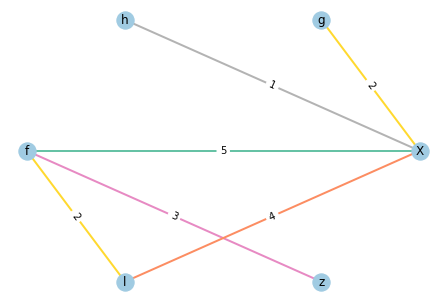

In [202]:
def draw_g(g, draw_options=GLOBAL_draw_options):
    nx.draw(g, edge_color=get_edge_colors(g), **draw_options)
    edge_labels = nx.get_edge_attributes(g, 'color')
    nx.draw_networkx_edge_labels(g, draw_options['pos'], edge_labels)

draw_g(g)

In [183]:
def find_maximal_fan(g, x, f):
    fan_x = [f]
    fan_is_maximal = True
    while fan_is_maximal:
        fan_is_maximal = False
        for _, v in g.edges(x):
            if (
                edge_is_colored(g, x, v)
                and color_is_free_at_vertex(g, get_edge_color(g, x, v), fan_x[-1])
                and v not in fan_x
            ):
                fan_x.append(v)
                fan_is_maximal = False
    return fan_x


fan_x = find_maximal_fan(g, X, f)
fan_x

['z', 'l', 'X']

In [184]:
def find_colors_cd(g: nx.Graph, x: NodeType, fan_x: FanType):
    l = fan_x[-1]
    c = d = next_color()
    while not color_is_free_at_vertex(g, c, x):
        c = next_color(c)
    while not color_is_free_at_vertex(g, d, l):
        d = next_color(d)
    return (c, d)


c, d = find_colors_cd(g, X, fan_x)
f'c: {c}, d: {d}'

'c: 2, d: 3'

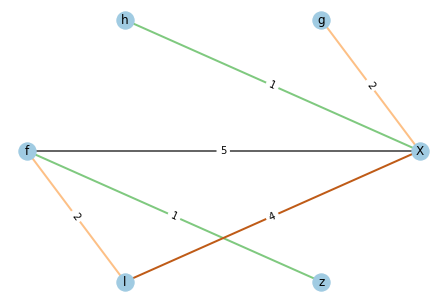

In [185]:
def find_and_invert_cd_path(
    g: nx.Graph, u: NodeType, c: ColorType, d: ColorType
) -> int:
    '''`u` is the `X` of the maximal fan.
    returns length of cd-path'''
    path_is_maximal = False
    seen = {u}
    while not path_is_maximal:
        path_is_maximal = True
        for v in g.neighbors(u):
            if d == get_edge_color(g, u, v) and v not in seen:
                set_edge_color(g, u, v, c)  # invert edge color
                u = v  # set vertex for next iter
                c, d = d, c  # swap colors
                path_is_maximal = False  # to loop over the new vertex
                seen |= {v}
                break  # next iter
    return len(seen) - 1


# gcpy = g.copy()
gcpy = g
cd_path_len = find_and_invert_cd_path(gcpy, X, c, d)
draw_g(gcpy)

In [186]:
def find_w_in_fan(g: nx.Graph, d: ColorType, fan_x: FanType) -> Tuple[int, NodeType]:
    for i, u in enumerate(fan_x):
        if color_is_free_at_vertex(g, d, u):
            return (i, u)
    return (-1, None)  # this line should be unreachable


w_idx, w = find_w_in_fan(gcpy, d, fan_x) if cd_path_len else (len(fan_x) - 1, fan_x[-1])
assert w_idx >= 0
w_idx, w

(0, 'z')

['z']


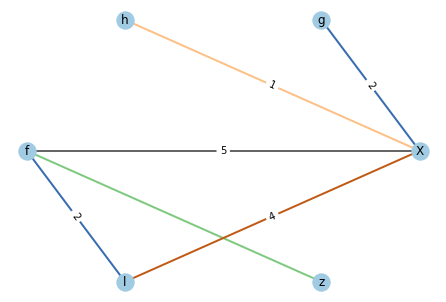

In [187]:
def rotate_fan(g: nx.Graph, x: NodeType, fan_prime_x: FanType) -> None:
    print(fan_prime_x)
    for u, v in zip(
        fan_prime_x, fan_prime_x[1:]
    ):  # zip(fan_prime_x[:-1], fan_prime_x[1:])
        g[x][u]['color'] = get_edge_color(g, x, v)
    rm_edge_color(
        g, x, fan_prime_x[-1]
    )  # Redundant since we set the edge's color after this function anyway.


rotate_fan(gcpy, X, fan_x[: w_idx + 1])
draw_g(gcpy)

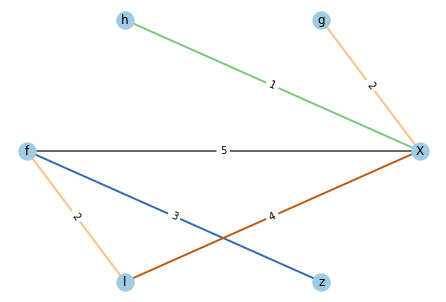

In [188]:
set_edge_color(gcpy, X, w, d)
edges -= {(X, f)}
draw_g(gcpy)